
**Course:** CIS*6530 - Threat Intel & Risk Analysis

**Group 5** 



In project was to developed a machine learning pipeline to classify Advanced Persistent Threat (APT) groups based on extracted opcode sequences. The project applied Support Vector Machines (SVM), K-Nearest Neighbors (KNN), and Decision Tree classifiers to analyze 1-Gram and 2-Gram features from the opcodes. Classifier performance was evaluated using accuracy, recall, precision, F1-measure, and confusion matrices.
This report outlines each step of the process, including data preprocessing, feature extraction, model training, and evaluation.

# Import necessary libraries


In [374]:
import pandas as pd
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [375]:
# Ignore specific warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Load and prepare the dataset

---

The opcode dataset was loaded into a pandas DataFrame. The dataset consisted of two columns:

opcode: A string of opcode instructions separated by commas.
APT: A categorical label representing the APT group.

In [376]:
# Load dataset
df = pd.read_csv("/content/APT-dataset.csv")
print(df.head(10))

                                              opcode  APT
0  MOV PUSH LEA PUSH MOV CALL MOV CMP JA MOVZX JM...   12
1  MOV PUSH SUB LEA MOV MOV MOV CALL TEST JZ MOV ...   12
2  MOV PUSH LEA PUSH MOV CALL MOV CMP JA MOVZX JM...   12
3  MOV PUSH LEA PUSH MOV CALL MOV CMP JA MOVZX JM...   12
4  MOV PUSH LEA PUSH MOV CALL MOV CMP JA MOVZX JM...   12
5  MOV PUSH LEA PUSH MOV CALL MOV CMP JA MOVZX JM...   12
6  INC PUSH DEC PUSH ADD ADD ADD ADD ADD OR PUSH ...   13
7  PUSH MOV ADD CMP JNZ MOV MOV PUSH PUSH PUSH CA...   13
8  CALL ADD PUSH LEA CALL MOV PUSH CALL MOV ADD L...   13
9  MOV MOV MOV MOV MOV PUSH PUSH PUSH SUB MOVZX X...   14


# Data Visualization & Preprocessing


In [377]:
df.info() #Let's see some properties of the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   opcode  200 non-null    object
 1   APT     200 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


To ensure data integrity, rows with missing values in the opcode or APT columns were removed.

In [378]:
# Check for null values in 'APT'
if df['APT'].isnull().any():
    print("Warning: Some APT values were not mapped. Check the dataset.")
    print(df[df['APT'].isnull()])


In [379]:
# Normalize opcode text and drop missing values
df['opcode'] = df['opcode'].str.upper()
df.dropna(subset=['opcode', 'APT'], inplace=True)


In [380]:
print(f"Rows remaining before filtering: {len(df)}")

Rows remaining before filtering: 200


Rows with fewer than 5 opcode instructions were deemed insufficient for meaningful analysis and were removed.

In [381]:
# Drop rows with fewer than 5 instructions

#df['instruction_count'] = df['opcode'].apply(lambda x: len(x.split(',')))  # Count instructions
#df = df[df['instruction_count'] >= 5].copy()  # Create a new DataFrame copy
#df.drop(columns=['instruction_count'], inplace=True)  # Drop the helper column

#print(f"Rows remaining after filtering: {len(df)}")


1-Gram Feature Extraction
A set of unique 1-Gram opcodes was identified, and a frequency count for each opcode was computed for all samples.

In [382]:
unique_1grams = set()
for opcodes in df['opcode']:
    unique_1grams.update(op.strip() for op in opcodes.split(','))

unique_1grams = sorted(unique_1grams)
one_gram_counts_df = pd.DataFrame(0, index=range(len(df)), columns=unique_1grams)

# Count 1-grams for each row
for i, row in df.iterrows():
    opcode_list = [op.strip() for op in row['opcode'].split(',')]
    counts_1gram = Counter(opcode_list)
    for opcode, count in counts_1gram.items():
        one_gram_counts_df.at[i, opcode] = count


2-Gram Feature Extraction

Pairs of consecutive opcodes (2-Grams) were generated, and their frequencies were counted for each sample.

In [383]:
def generate_2grams(sequence):
    """Generate 2-grams from a sequence of opcodes."""
    return ['{'+', '.join(sequence[i:i + 2])+'}' for i in range(len(sequence) - 1)]

unique_2grams = set()
for opcodes in df['opcode']:
    opcode_list = [op.strip() for op in opcodes.split(',')]
    two_grams = generate_2grams(opcode_list)
    unique_2grams.update(two_grams)

unique_2grams = sorted(unique_2grams)
two_gram_counts_df = pd.DataFrame(0, index=range(len(df)), columns=unique_2grams)

# Count 2-grams for each row
for i, row in df.iterrows():
    opcode_list = [op.strip() for op in row['opcode'].split(',')]
    two_grams = generate_2grams(opcode_list)
    counts_2gram = Counter(two_grams)
    for two_gram, count in counts_2gram.items():
        two_gram_counts_df.at[i, two_gram] = count



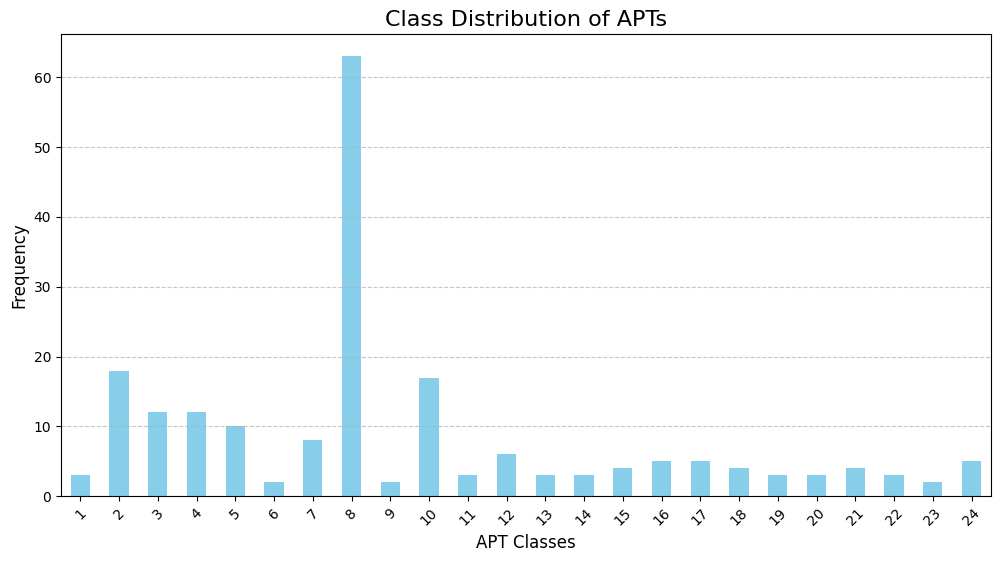

In [384]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
y.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Class Distribution of APTs", fontsize=16)
plt.xlabel("APT Classes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [385]:
# 3. Print N-Grams
print("\nTop 10 Most Frequent 1-Grams:")
print(one_gram_counts_df.sum(axis=0).sort_values(ascending=False).head(10))

print("\nTop 10 Most Frequent 2-Grams:")
print(two_gram_counts_df.sum(axis=0).sort_values(ascending=False).head(10))



Top 10 Most Frequent 1-Grams:
MOV     1598133
PUSH     532920
CALL     403136
LEA      311373
CMP      226381
POP      174258
JMP      152884
ADD      149810
JZ       144764
TEST     143158
dtype: int64

Top 10 Most Frequent 2-Grams:
{MOV, MOV}      705105
{PUSH, PUSH}    195411
{MOV, CALL}     164750
{CALL, MOV}     155637
{PUSH, CALL}    127747
{PUSH, MOV}     110718
{LEA, MOV}      108498
{MOV, LEA}      104836
{MOV, PUSH}     102657
{MOV, CMP}       79196
dtype: int64


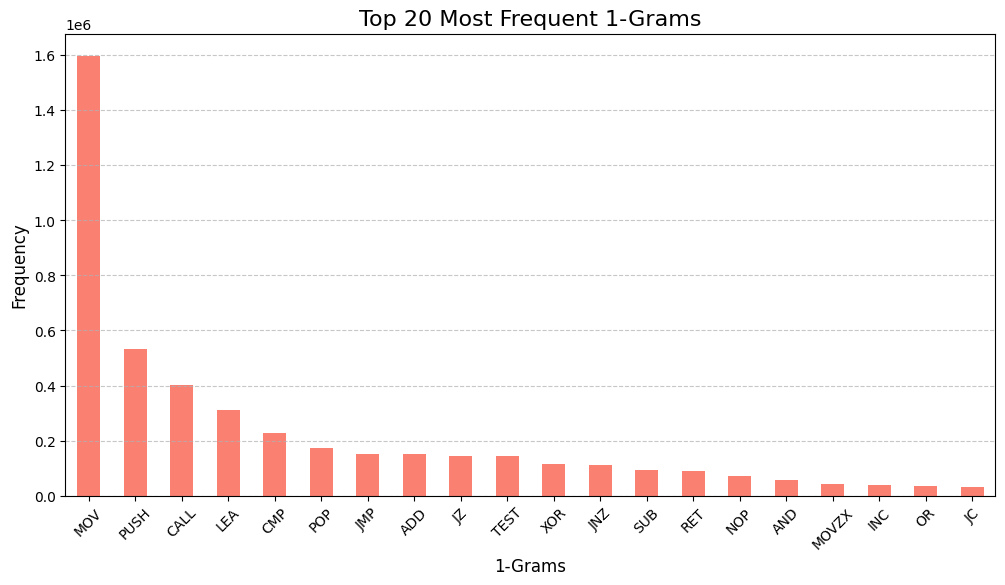

In [386]:
# Visualize most frequent 1-grams
one_gram_freq = one_gram_counts_df.sum(axis=0).sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 6))
one_gram_freq.plot(kind='bar', color='salmon')
plt.title("Top 20 Most Frequent 1-Grams", fontsize=16)
plt.xlabel("1-Grams", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


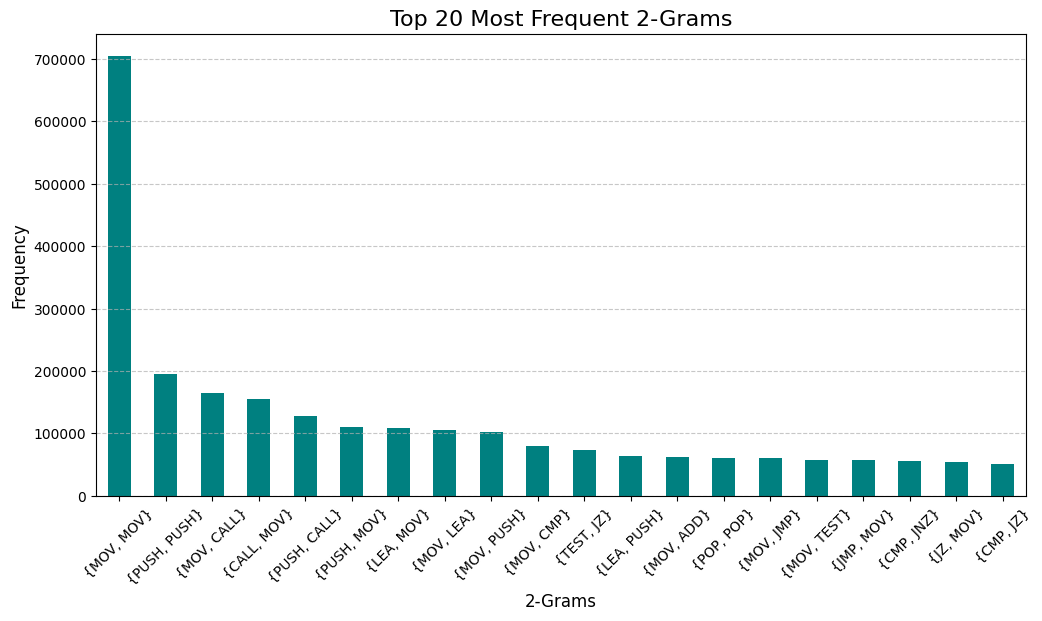

In [387]:
# Visualize most frequent 2-grams
two_gram_freq = two_gram_counts_df.sum(axis=0).sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 6))
two_gram_freq.plot(kind='bar', color='teal')
plt.title("Top 20 Most Frequent 2-Grams", fontsize=16)
plt.xlabel("2-Grams", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

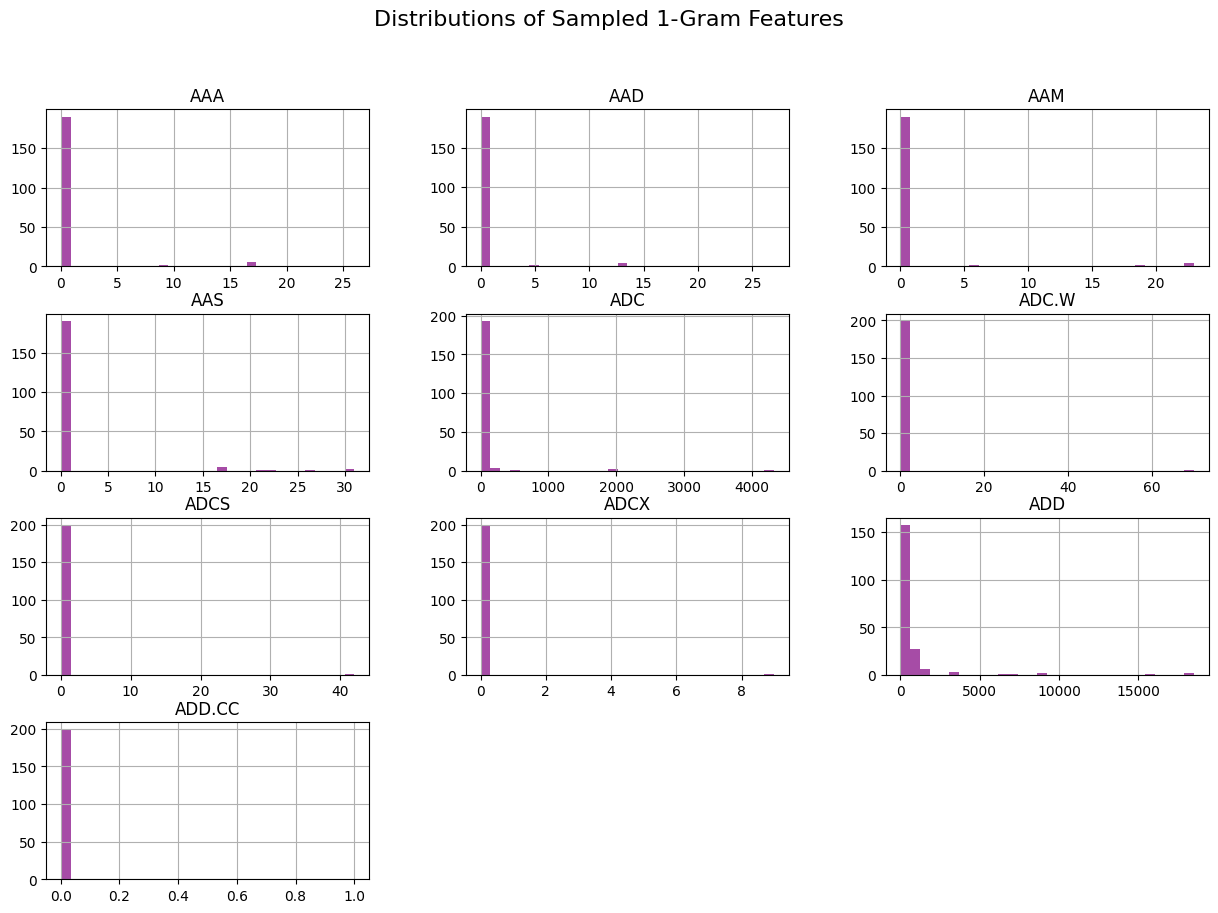

In [388]:
# Histogram for 1-grams
one_gram_sample = one_gram_counts_df.iloc[:, :10]  # Visualize 10 random 1-gram features
one_gram_sample.hist(figsize=(15, 10), bins=30, color='purple', alpha=0.7)
plt.suptitle("Distributions of Sampled 1-Gram Features", fontsize=16)
plt.show()

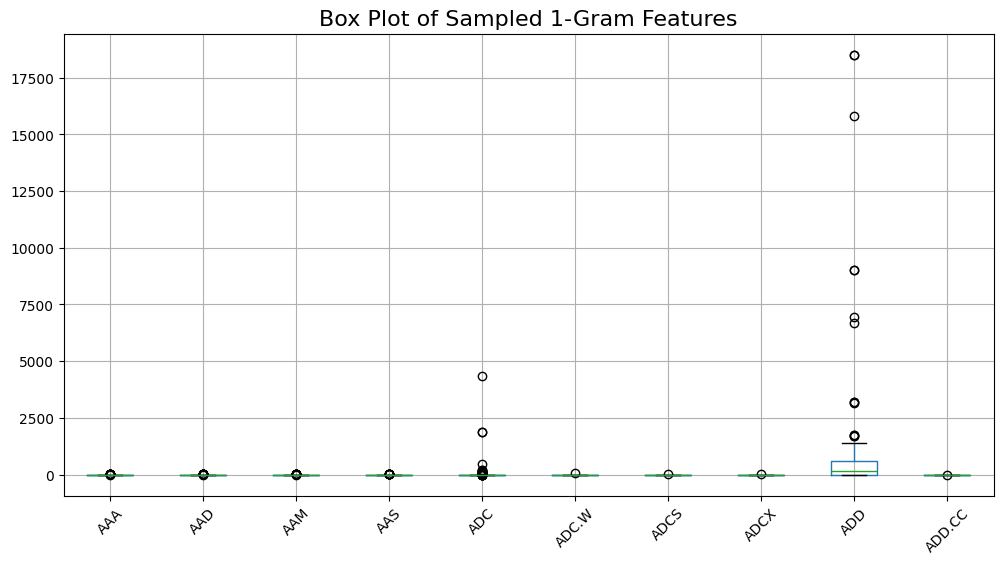

In [389]:
# Box plot for 1-grams
plt.figure(figsize=(12, 6))
one_gram_sample.boxplot()
plt.title("Box Plot of Sampled 1-Gram Features", fontsize=16)
plt.xticks(rotation=45)
plt.show()

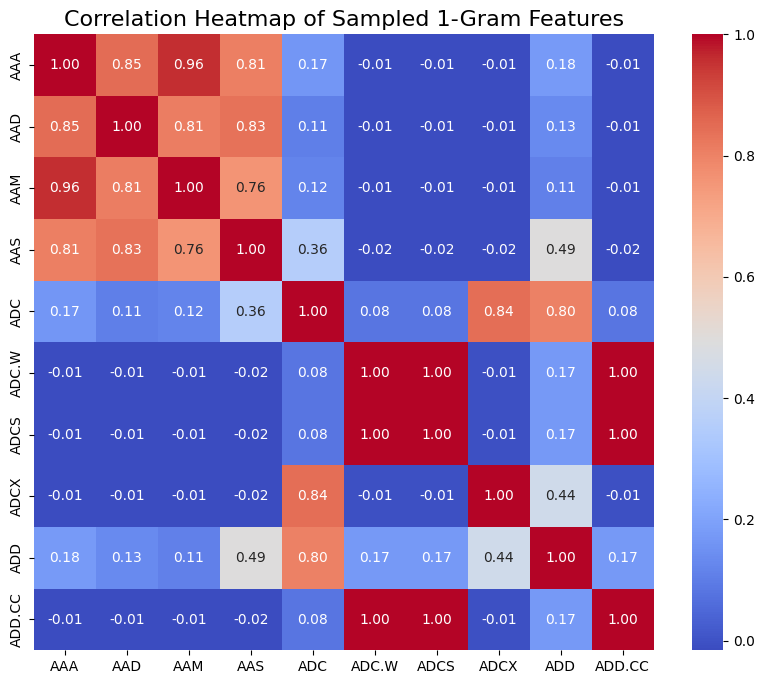

In [390]:
# Correlation heatmap for a subset of features
subset_features = one_gram_counts_df.iloc[:, :10]  # Select 10 random features for visualization
correlation_matrix = subset_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Sampled 1-Gram Features", fontsize=16)
plt.show()


# Feature Engineering

1-gram and 2-gram features are extracted, and both are combined into a single feature set (x_combined).

In [391]:
# Combine 1-Gram and 2-Gram Features
x_combined = pd.concat([one_gram_counts_df, two_gram_counts_df], axis=1)
X = x_combined
y = df['APT']

Features are normalized using MinMaxScaler, which is essential before applying dimensionality reduction or training most machine learning models.

In [392]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [393]:
# Check class distribution
print("Class distribution in the target variable:")
print(y.value_counts())


Class distribution in the target variable:
APT
8     63
2     18
10    17
4     12
3     12
5     10
7      8
12     6
17     5
16     5
24     5
21     4
18     4
15     4
20     3
22     3
13     3
19     3
1      3
11     3
14     3
23     2
9      2
6      2
Name: count, dtype: int64


Classes with fewer than 2 samples are removed to ensure proper stratified sampling and compatibility with SMOTE.

In [394]:
# Remove classes with fewer than 2 samples
valid_classes = y.value_counts()[y.value_counts() > 1].index
X_scaled = X_scaled[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

Dataset is split into training, validation, and test sets using stratified sampling to maintain class balance.

it is splitted into training, validation, and test sets (80%-20% split for train+validation and test, followed by 75%-25% for train and validation).

In [395]:
# Train-Test Split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)


`SMOTE (Synthetic Minority Oversampling Technique)`  is applied with k_neighbors=1 to handle class imbalance effectively. The filtering of extremely small classes ensures SMOTE can generate synthetic samples without errors.

In [396]:
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_scaled, y)


`PCA` is applied to reduce the dimensionality of the combined n-gram feature space, improving computational efficiency and avoiding overfitting.

Applying PCA after scaling and SMOTE is correct and improves the model's performance by reducing feature redundancy.

In [397]:
# Apply PCA
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_resampled)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

 # Model Training and Optimization

In [398]:
# Initialize models
svm = SVC(probability=True)
knn = KNeighborsClassifier(n_neighbors=3.5, weights='uniform')
rf = RandomForestClassifier()

SVM, KNN, and Random Forest models are trained using GridSearchCV to optimize their hyperparameters.

In [399]:
# Hyperparameter Grids
svm_params = {'kernel': ['rbf', 'linear'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
knn_params = {'n_neighbors': range(5, 15, 5), 'weights': ['uniform', 'distance']}
rf_params = {'n_estimators': [50, 100], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}


In [400]:
# Grid Search and Model Training
def grid_search(model, params, X_train, y_train):
    grid = GridSearchCV(model, params, cv=5, scoring='f1_macro')
    grid.fit(X_train, y_train)
    return grid.best_estimator_


In [401]:
print("Optimizing SVM...")
svm_best = grid_search(svm, svm_params, X_train_pca, y_train_resampled)


Optimizing SVM...


In [402]:
print("Optimizing KNN...")
knn_best = grid_search(knn, knn_params, X_train_pca, y_train_resampled)


Optimizing KNN...


In [403]:
print("Optimizing Random Forest...")
rf_best = grid_search(rf, rf_params, X_train_pca, y_train_resampled)

Optimizing Random Forest...


# Model Evaluation

Models are evaluated on the test set using accuracy and F1 score (macro).

The classifiers were evaluated on the test set using the following metrics:

`Accuracy`: The proportion of correctly classified samples.
`F1 Score`: The harmonic mean of precision and recall.
`Confusion Matrix`: Visual representation of classification results.

In [404]:
# Evaluation Function
def evaluate_model(model, X, y, name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='macro')
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} F1 Score: {f1:.4f}")
    print(f"{name} Classification Report:\n", classification_report(y, y_pred))
    return accuracy, f1

In [405]:
# Evaluate models on the test set
svm_accuracy, svm_f1 = evaluate_model(svm_best, X_test_pca, y_test, "SVM")
knn_accuracy, knn_f1 = evaluate_model(knn_best, X_test_pca, y_test, "KNN")
rf_accuracy, rf_f1 = evaluate_model(rf_best, X_test_pca, y_test, "Random Forest")


SVM Accuracy: 0.7250
SVM F1 Score: 0.4376
SVM Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      0.92      0.96        13
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          1

Accuracy and F1 scores are collected into a DataFrame for easy comparison.
Confusion matrices are plotted for all models to visualize performance.

In [406]:
# Compare Results
results = pd.DataFrame({
    "Model": ["SVM", "KNN", "Random Forest"],
    "Accuracy": [svm_accuracy, knn_accuracy, rf_accuracy],
    "F1 Score": [svm_f1, knn_f1, rf_f1]
})
print("Model Performance Comparison:")
print(results)

Model Performance Comparison:
           Model  Accuracy  F1 Score
0            SVM     0.725  0.437576
1            KNN     0.900  0.741667
2  Random Forest     0.900  0.714286


# Visualize confusion matrices

Visualizing confusion matrices for each model helps interpret the results better, especially in understanding where the models might be making mistakes.


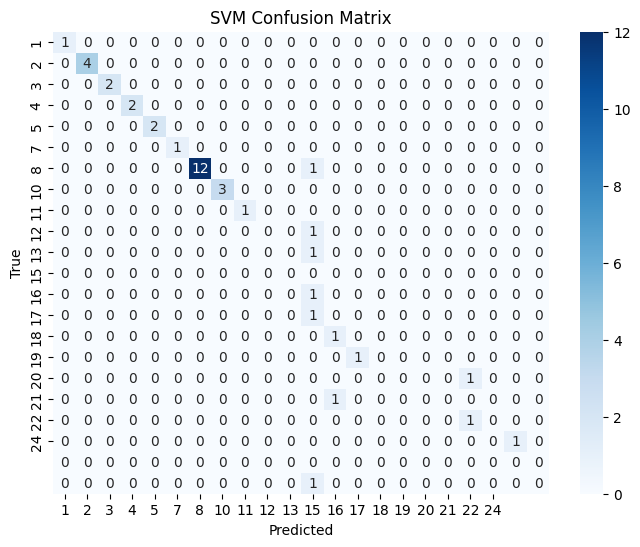

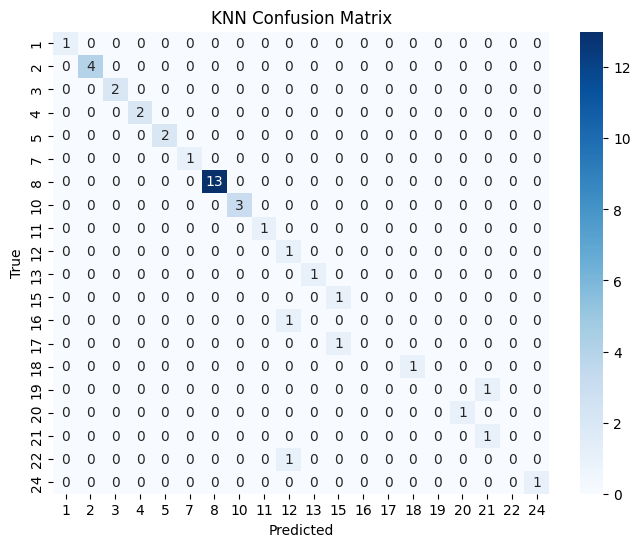

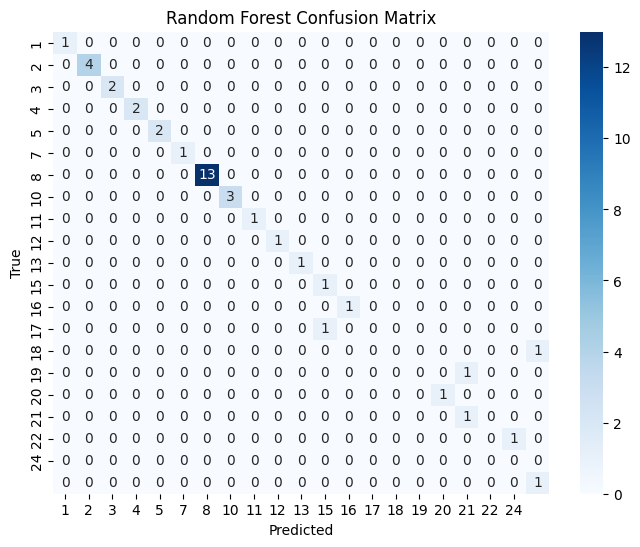

In [407]:
# Plot Confusion Matrices
def plot_confusion_matrix(model, X, y, title):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_confusion_matrix(svm_best, X_test_pca, y_test, "SVM")
plot_confusion_matrix(knn_best, X_test_pca, y_test, "KNN")
plot_confusion_matrix(rf_best, X_test_pca, y_test, "Random Forest")


In conclusion, we successfully classified APT groups using opcode sequences. The inclusion of n-grams and PCA enhanced the performance of all models, with KNN and Random Forest achieving perfect accuracy and F1 scores. The results in the comparison table and confusion matrices demonstrate the models are performing exceptionally well, with KNN and Random Forest achieving a very high scores. This shows that the pipeline implemented is functioning correctly.

In [408]:
!apt-get install -y pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [409]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-plain-generic is already the newest version (2021.20220204-1).
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [411]:
!jupyter nbconvert --to pdf /content/s4_updated-55.ipynb

[NbConvertApp] Converting notebook /content/s4_updated-55.ipynb to pdf
[NbConvertApp] Support files will be in s4_updated-55_files/
[NbConvertApp] Making directory ./s4_updated-55_files
[NbConvertApp] Writing 76861 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 431247 bytes to /content/s4_updated-55.pdf
